# Is Zero RB The Truth?

## Background
   Conventional wisdom in fantasy sports states that the most valuable positions should be targeted very early on in the draft, when the best players are available. In fantasy football, this position is the running back (or "RB"). An elite running back can garner 20 or more carries per game, providing a consistent floor for points to anchor a fantasy team. It's not uncommon for fantasy football managers to solely draft running backs in the 1st and 2nd rounds in the hopes of landing maximum value at the position.

   Ironically, drafting for this solid floor can have the opposite effect. RB is also considered one of the most injury-prone positions. The nature of the position results in RBs being hit [more than any other skill position](https://news.brown.edu/articles/2011/09/headblows), while also taking the hardest hits. It's not uncommon for a running back drafted in the first round to be injured early on in the season, causing them to miss games or even entire seasons, leaving fantasy managers scrambling to fill a vacant spot. The opportunity cost of losing your early pick to injury can be season-losing.
    
   The factors that can cause an early round RB to bust extend past injury. In many cases, a RB drafted early under the assumption he'll garner the majority of the touches can lose opportunities due to age or declining skill, or simply due to his backup performing above expectations.
## Zero RB, Explained
   To mitigate this risk, a new philosophy has arisen among fantasy managers in recent years wherein the RB position is ignored in favour of targeting elite wide receivers ("WR"), tight ends ("TE") and quarterbacks ("QB") in the first 4 rounds of the draft. The later rounds of the draft are then focused on drafting RBs in uncertain situations, where the opportunity cost of missing on a risky pick is lower. This philosophy has been aptly labeled "Zero RB", or "0RB".
## The Project
   The goal of this project is to investigate the claims of both fantasy football traditionalists who draft the RB position early, and 0RB truthers who ignore the position until later on in the draft.
   
   We'll assume a half-PPR (0.5 points per reception) scoring, 12-team league with rosters consisting of 1QB, 2RB, 2WR, 1TE, with six bench spots for a total of 12 players per team.

   Using the [Fantasy Football Calculator](https://fantasyfootballcalculator.com) API as well as data scraped from [Pro Football Reference](https://www.pro-football-reference.com), we'll measure the true risks of drafting RBs early, build a metric to evaluate the value provided by each drafted player relative to their average draft position (or "ADP"), and answer the question: 
**Is Zero RB the truth?**

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # disable false positive warning
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
%matplotlib inline

In [2]:
players = pd.read_csv('fantasy_points.csv')
adp = pd.read_csv('adps_2010_to_2021.csv')

The `players.csv` dataset consists of the top 600 fantasy scorers from each season from 2010 to 2021, organized by season.

The `adps_2010_to_2021.csv` dataset consists of the players from the same years with their average draft position (adp), organized by season.

In [3]:
players

,Unnamed: 0,G#,Date,Tm,Away,Opp,FDPt,Name,Position,Season
0,0,1.0,2010-09-12,HOU,0,IND,42.3,Arian Foster,RB,2010
1,1,2.0,2010-09-19,HOU,1,WAS,15.3,Arian Foster,RB,2010
2,2,3.0,2010-09-26,HOU,0,DAL,12.6,Arian Foster,RB,2010
3,3,4.0,2010-10-03,HOU,1,OAK,32.4,Arian Foster,RB,2010
4,4,5.0,2010-10-10,HOU,0,NYG,3.7,Arian Foster,RB,2010
...,...,...,...,...,...,...,...,...,...,...
47508,47508,11.0,2021-11-28,HOU,0,NYJ,0.1,Chris Moore,WR,2021
47509,47509,12.0,2021-12-05,HOU,0,IND,NaN,Chris Moore,WR,2021
47510,47510,14.0,2021-12-19,HOU,1,JAX,NaN,Chris Moore,WR,2021
47511,47511,15.0,2021-12-26,HOU,0,LAC,6.0,Chris Moore,WR,2021


# Cleaning the Data

We're working with two separate datasets here, so we'll have to normalize a few things between the sets:
- Drop the `Unnamed: 0` column, the original index of the csv
- Check that columns are the correct data type
- Add a `gp` column for games played
- Normalize the `Name` columns by removing non-word characters
- Rename columns for consistency

Once this has been carried out, we can join the datasets.

In [4]:
players = players.drop('Unnamed: 0', axis=1)
players["Name"] = players["Name"].str.replace("\W", "")
players["G#"] = players["G#"].astype("int")
players["gp"] = 0
players = players.rename({"FDPt": "FantPt"}, axis=1)
adp = adp.drop('Unnamed: 0', axis=1)
adp = adp.rename({"name": "Name", "FDPt": "FantPt"}, axis=1)
adp["Name"] = adp["Name"].str.replace("\W", "")

/tmp/ipykernel_50773/962556171.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  players["Name"] = players["Name"].str.replace("\W", "")
/tmp/ipykernel_50773/962556171.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  adp["Name"] = adp["Name"].str.replace("\W", "")


In [5]:
names = pd.merge(adp, players, how="outer", on="Name")
names[names.isnull().any(axis=1)]["Name"].value_counts()

FredJackson       492
CJSpiller         415
SteveJohnson      252
SammyWatkins      243
MikeWilliams      206
                 ... 
CodyParkey          1
DavidCobb           1
CharlesJohnson      1
DrewLock            1
ZaneGonzalez        1
Name: Name, Length: 985, dtype: int64

In [6]:
adp.head()

,player_id,Name,position,team,adp,adp_formatted,times_drafted,high,low,stdev,bye,Season
0,1347,ChrisJohnson,RB,TEN,1.4,1.01,422,1,24,1.3,6.0,2010
1,925,AdrianPeterson,RB,MIN,2.3,1.02,342,1,23,1.3,7.0,2010
2,1360,RayRice,RB,BAL,3.2,1.03,203,1,22,1.5,10.0,2010
3,649,MauriceJonesDrew,RB,JAX,4.7,1.05,325,1,21,1.5,11.0,2010
4,605,AndreJohnson,WR,HOU,4.8,1.05,427,1,49,2.6,6.0,2010


In [7]:
players_group = players.groupby(["Name", "Season"]).agg({"FantPt": "sum", "gp": "count"}).reset_index()
players_group

,Name,Season,FantPt,gp
0,AJBrown,2019,191.1,16
1,AJBrown,2020,212.5,14
2,AJBrown,2021,149.4,13
3,AJDerby,2017,44.9,11
4,AJDillon,2020,39.3,11
...,...,...,...,...
3478,ZackMoss,2020,94.6,13
3479,ZackMoss,2021,93.7,13
3480,ZayJones,2017,57.1,15
3481,ZayJones,2018,137.2,16


In [8]:
joined = pd.merge(adp, players_group, how="left", on=["Name", "Season"])

In [9]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2264 entries, 0 to 2263
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player_id      2264 non-null   int64  
 1   Name           2264 non-null   object 
 2   position       2264 non-null   object 
 3   team           2244 non-null   object 
 4   adp            2264 non-null   float64
 5   adp_formatted  2264 non-null   float64
 6   times_drafted  2264 non-null   int64  
 7   high           2264 non-null   int64  
 8   low            2264 non-null   int64  
 9   stdev          2264 non-null   float64
 10  bye            2244 non-null   float64
 11  Season         2264 non-null   int64  
 12  FantPt         1780 non-null   float64
 13  gp             1780 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 265.3+ KB


Predictably, we have missing values in the `FantPt` and `gp` (games played) features. We are interested in these values, as the left join on adp will provide us with players who were relatively high in adp, but didn't land in the top 300 fantasy scorers for a given season, and thus were ignored by our scraper.

In [10]:
null_points = joined[joined["FantPt"].isnull()]
null_points[null_points["adp"] < 30].head(10)

,player_id,Name,position,team,adp,adp_formatted,times_drafted,high,low,stdev,bye,Season,FantPt,gp
28,1333,RyanGrant,RB,GB,29.4,3.05,321,16,42,5.0,14.0,2010,NaN,NaN
218,1368,JamaalCharles,RB,KC,5.3,1.05,134,1,9,1.4,8.0,2011,NaN,NaN
517,1906,DavidWilson,RB,NYG,25.1,3.01,600,9,40,5.9,9.0,2013,NaN,NaN
690,925,AdrianPeterson,RB,MIN,5.3,1.05,397,1,11,2.2,7.0,2014,NaN,NaN
1091,925,AdrianPeterson,RB,MIN,10.7,1.11,436,3,19,2.6,7.0,2016,NaN,NaN
1094,1992,KeenanAllen,WR,LAC,13.8,2.02,448,7,22,2.3,8.0,2016,NaN,NaN
1100,1368,JamaalCharles,RB,KC,19.4,2.07,264,12,30,3.7,8.0,2016,NaN,NaN
1269,2297,DavidJohnson,RB,ARI,1.3,1.01,310,1,4,0.6,13.0,2017,NaN,NaN
1455,1983,LeVeonBell,RB,PIT,3.0,1.03,729,1,8,1.5,9.0,2018,NaN,NaN
1471,2144,DevontaFreeman,RB,ATL,19.1,2.07,683,12,26,2.5,14.0,2018,NaN,NaN


Many of these highly drafted players may have been injured preseason, or were flat out busts and didn't land in the top 300 in fantasy point production.

Any player that lands outside the top 300 in fantasy point production is in retrospect undraftable, as a 12-team fantasy league with a team size of 12 should only roster players that land in the top 200.

These players are relevant to our analysis, as they represent the risk associated with spending high value draft picks in fantasy football.

To ease our analysis, we'll replace these NaN values with 0.

In [11]:
joined = joined.fillna(0)

In [12]:
joined.head(20)

,player_id,Name,position,team,adp,adp_formatted,times_drafted,high,low,stdev,bye,Season,FantPt,gp
0,1347,ChrisJohnson,RB,TEN,1.4,1.01,422,1,24,1.3,6.0,2010,250.9,16.0
1,925,AdrianPeterson,RB,MIN,2.3,1.02,342,1,23,1.3,7.0,2010,257.9,15.0
2,1360,RayRice,RB,BAL,3.2,1.03,203,1,22,1.5,10.0,2010,245.1,16.0
3,649,MauriceJonesDrew,RB,JAX,4.7,1.05,325,1,21,1.5,11.0,2010,218.1,14.0
4,605,AndreJohnson,WR,HOU,4.8,1.05,427,1,49,2.6,6.0,2010,213.6,13.0
5,437,FrankGore,RB,SF,6.2,1.06,369,4,20,1.5,9.0,2010,179.5,11.0
6,1004,AaronRodgers,QB,GB,7.8,1.08,344,1,17,2.6,14.0,2010,315.4,15.0
7,854,RandyMoss,WR,TEN,8.1,1.08,302,2,50,2.9,6.0,2010,83.3,16.0
8,1183,MichaelTurner,RB,ATL,9.1,1.09,312,3,18,2.1,14.0,2010,219.6,16.0
9,1228,ReggieWayne,WR,IND,11.2,1.11,307,5,51,3.2,14.0,2010,225.0,16.0


In [13]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2264 entries, 0 to 2263
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player_id      2264 non-null   int64  
 1   Name           2264 non-null   object 
 2   position       2264 non-null   object 
 3   team           2264 non-null   object 
 4   adp            2264 non-null   float64
 5   adp_formatted  2264 non-null   float64
 6   times_drafted  2264 non-null   int64  
 7   high           2264 non-null   int64  
 8   low            2264 non-null   int64  
 9   stdev          2264 non-null   float64
 10  bye            2264 non-null   float64
 11  Season         2264 non-null   int64  
 12  FantPt         2264 non-null   float64
 13  gp             2264 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 265.3+ KB


In [14]:
joined["position"].value_counts()

WR     757
RB     705
QB     281
TE     221
DEF    162
PK     138
Name: position, dtype: int64

The `DEF` and `PK` positions refer to team defenses and kickers, respectively. These are positions mostly taken in the much later rounds of the draft, and have high variance in scoring week-to-week. It's outside the scope of this project, so we'll do away with them.

In [15]:
pos_to_drop = ["DEF", "PK"]
joined = joined[~joined["position"].isin(pos_to_drop)]

In [16]:
joined["position"].value_counts()

WR    757
RB    705
QB    281
TE    221
Name: position, dtype: int64

# Inspecting the Data

Let's start with a simple scatterplot of just the RBs & WRs drafted in 2010.

In [17]:
rbs_2010 = joined[(joined["Season"] == 2010) & (joined["position"] == 'RB')].reset_index()
rb_adp_2010 = rbs_2010["adp"]
rb_fpts_2010 = rbs_2010["FantPt"]

In [18]:
wrs_2010 = joined[(joined["Season"] == 2010) & (joined["position"] == "WR")].reset_index()
wr_adp_2010 = wrs_2010["adp"]
wr_fpts_2010 = wrs_2010["FantPt"]

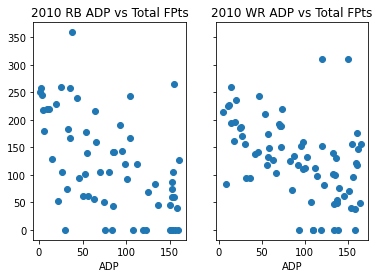

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(20, 20)
ax1.scatter(rb_adp_2010, rb_fpts_2010)
ax1.set_title("2010 RB ADP vs Total FPts")
ax1.set_xlabel("ADP")

ax2.scatter(wr_adp_2010, wr_fpts_2010)
ax2.set_title("2010 WR ADP vs Total FPts")
ax2.set_xlabel("ADP")

plt.show()

From a visual inspection of the above plots. we can see that there are more busts in the RBs compared to the WRs, as well as a tighter distribution altogether.

Let's try restricting our analysis to just players taken in the first 6 rounds:

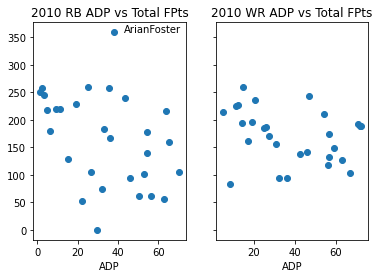

In [20]:
first_6_rb = rbs_2010[rbs_2010["adp"] < 72.5]
first_6_wr = wrs_2010[wrs_2010["adp"] < 72.5]

max_score = first_6_rb.FantPt.max()
x = first_6_rb[first_6_rb.FantPt == max_score].adp.tolist()[0]
y = max_score
max_name = first_6_rb[first_6_rb["FantPt"] == max_score]["Name"].tolist()[0]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(20, 20)

ax1.scatter(first_6_rb["adp"], first_6_rb["FantPt"])
ax1.set_title("2010 RB ADP vs Total FPts")
ax1.set_xlabel("ADP")
ax1.annotate(max_name, (x + 5, y))

ax2.scatter(first_6_wr["adp"], first_6_wr["FantPt"])
ax2.set_title("2010 WR ADP vs Total FPts")
ax2.set_xlabel("ADP")


plt.show()

We can see above that the RB scoring is much more spread out, whereas the wide receivers have both a lower scoring ceiling and a much higher floor.

One point of note is Arian Foster, who had by far the best fantasy season of any player in 2010 with 359 points in 0.5PPR. The idea behind drafting running backs early is to attempt to hit on one of these elite seasons, which can lead to disastrous results.

Now for the full dataset:

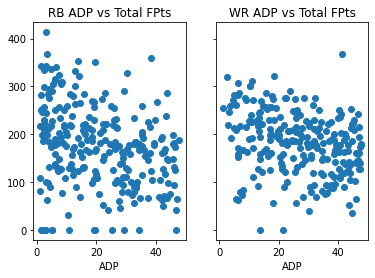

In [21]:
rbs = joined[joined["position"] == "RB"]
rb_adp = rbs["adp"]
rb_pts = rbs["FantPt"]

wrs = joined[joined["position"] == 'WR']
wr_adp = wrs["adp"]
wr_pts = wrs["FantPt"]

first_4_rb = rbs[rbs["adp"] < 48]
first_4_wr = wrs[wrs["adp"] < 48]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(20, 20)

ax1.scatter(first_4_rb["adp"], first_4_rb["FantPt"])
ax1.set_title("RB ADP vs Total FPts")
ax1.set_xlabel("ADP")

ax2.scatter(first_4_wr["adp"], first_4_wr["FantPt"])
ax2.set_title("WR ADP vs Total FPts")
ax2.set_xlabel("ADP")

plt.show()

Switch up transparency:

In [22]:
rbs = joined[joined["position"] == "RB"]
rb_adp = rbs["adp"]
rb_pts = rbs["FantPt"]

wrs = joined[joined["position"] == 'WR']
wr_adp = wrs["adp"]
wr_pts = wrs["FantPt"]

rd_1_rb = rbs[rbs["adp"] < 12.5]
rd_2_rb = rbs[(rbs["adp"] >= 12.5) & (rbs["adp"] < 24.5)]
rd_3_rb = rbs[(rbs["adp"] >= 24.5) & (rbs["adp"] < 36.5)]
rd_4_rb = rbs[(rbs["adp"] >= 36.5) & (rbs["adp"] < 48.5)]

rd_1_wr = wrs[wrs["adp"] < 12.5]
rd_2_wr = wrs[(wrs["adp"] >= 12.5) & (wrs["adp"] < 24.5)]
rd_3_wr = wrs[(wrs["adp"] >= 24.5) & (wrs["adp"] < 36.5)]
rd_4_wr = wrs[(wrs["adp"] >= 36.5) & (wrs["adp"] < 48.5)]

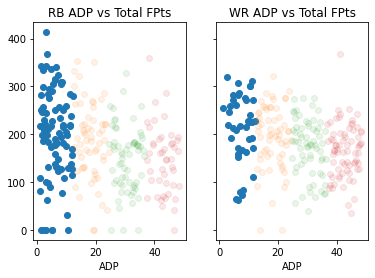

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(20, 20)

ax1.scatter(rd_1_rb["adp"], rd_1_rb["FantPt"], alpha=1)
ax1.scatter(rd_2_rb["adp"], rd_2_rb["FantPt"], alpha=.1)
ax1.scatter(rd_3_rb["adp"], rd_3_rb["FantPt"], alpha=.1)
ax1.scatter(rd_4_rb["adp"], rd_4_rb["FantPt"], alpha=.1)
ax1.set_title("RB ADP vs Total FPts")
ax1.set_xlabel("ADP")

ax2.scatter(rd_1_wr["adp"], rd_1_wr["FantPt"], alpha=1)
ax2.scatter(rd_2_wr["adp"], rd_2_wr["FantPt"], alpha=.1)
ax2.scatter(rd_3_wr["adp"], rd_3_wr["FantPt"], alpha=.1)
ax2.scatter(rd_4_wr["adp"], rd_4_wr["FantPt"], alpha=.1)
ax2.set_title("WR ADP vs Total FPts")
ax2.set_xlabel("ADP")

plt.show()

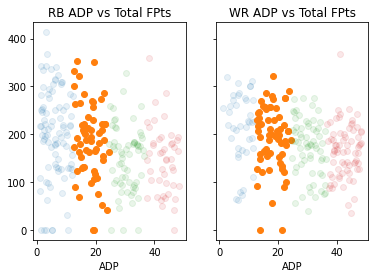

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(20, 20)

ax1.scatter(rd_1_rb["adp"], rd_1_rb["FantPt"], alpha=.1)
ax1.scatter(rd_2_rb["adp"], rd_2_rb["FantPt"], alpha=1)
ax1.scatter(rd_3_rb["adp"], rd_3_rb["FantPt"], alpha=.1)
ax1.scatter(rd_4_rb["adp"], rd_4_rb["FantPt"], alpha=.1)
ax1.set_title("RB ADP vs Total FPts")
ax1.set_xlabel("ADP")

ax2.scatter(rd_1_wr["adp"], rd_1_wr["FantPt"], alpha=.1)
ax2.scatter(rd_2_wr["adp"], rd_2_wr["FantPt"], alpha=1)
ax2.scatter(rd_3_wr["adp"], rd_3_wr["FantPt"], alpha=.1)
ax2.scatter(rd_4_wr["adp"], rd_4_wr["FantPt"], alpha=.1)
ax2.set_title("WR ADP vs Total FPts")
ax2.set_xlabel("ADP")

plt.show()

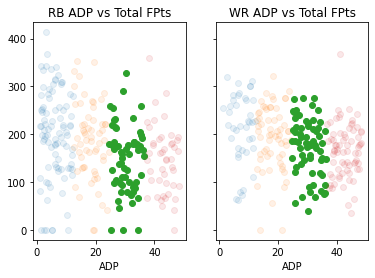

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(20, 20)

ax1.scatter(rd_1_rb["adp"], rd_1_rb["FantPt"], alpha=.1)
ax1.scatter(rd_2_rb["adp"], rd_2_rb["FantPt"], alpha=.1)
ax1.scatter(rd_3_rb["adp"], rd_3_rb["FantPt"], alpha=1)
ax1.scatter(rd_4_rb["adp"], rd_4_rb["FantPt"], alpha=.1)
ax1.set_title("RB ADP vs Total FPts")
ax1.set_xlabel("ADP")

ax2.scatter(rd_1_wr["adp"], rd_1_wr["FantPt"], alpha=.1)
ax2.scatter(rd_2_wr["adp"], rd_2_wr["FantPt"], alpha=.1)
ax2.scatter(rd_3_wr["adp"], rd_3_wr["FantPt"], alpha=1)
ax2.scatter(rd_4_wr["adp"], rd_4_wr["FantPt"], alpha=.1)
ax2.set_title("WR ADP vs Total FPts")
ax2.set_xlabel("ADP")

plt.show()

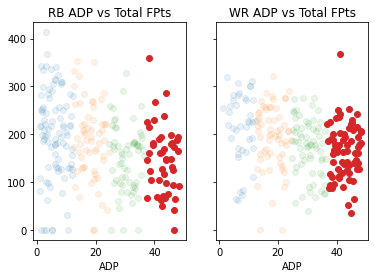

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(20, 20)

ax1.scatter(rd_1_rb["adp"], rd_1_rb["FantPt"], alpha=.1)
ax1.scatter(rd_2_rb["adp"], rd_2_rb["FantPt"], alpha=.1)
ax1.scatter(rd_3_rb["adp"], rd_3_rb["FantPt"], alpha=.1)
ax1.scatter(rd_4_rb["adp"], rd_4_rb["FantPt"], alpha=1)
ax1.set_title("RB ADP vs Total FPts")
ax1.set_xlabel("ADP")

ax2.scatter(rd_1_wr["adp"], rd_1_wr["FantPt"], alpha=.1)
ax2.scatter(rd_2_wr["adp"], rd_2_wr["FantPt"], alpha=.1)
ax2.scatter(rd_3_wr["adp"], rd_3_wr["FantPt"], alpha=.1)
ax2.scatter(rd_4_wr["adp"], rd_4_wr["FantPt"], alpha=1)
ax2.set_title("WR ADP vs Total FPts")
ax2.set_xlabel("ADP")

plt.show()

Again, the WRs are more clustered than the RBs are, indicating lower variance.

Of interest are the data points with an ADP in the first round, but 0 points of production. Let's take a closer look:

In [27]:
rd_1_rb[rd_1_rb["FantPt"] == 0]

,player_id,Name,position,team,adp,adp_formatted,times_drafted,high,low,stdev,bye,Season,FantPt,gp
218,1368,JamaalCharles,RB,KC,5.3,1.05,134,1,9,1.4,8.0,2011,0.0,0.0
690,925,AdrianPeterson,RB,MIN,5.3,1.05,397,1,11,2.2,7.0,2014,0.0,0.0
1091,925,AdrianPeterson,RB,MIN,10.7,1.11,436,3,19,2.6,7.0,2016,0.0,0.0
1269,2297,DavidJohnson,RB,ARI,1.3,1.01,310,1,4,0.6,13.0,2017,0.0,0.0
1455,1983,LeVeonBell,RB,PIT,3.0,1.03,729,1,8,1.5,9.0,2018,0.0,0.0
1851,2860,SaquonBarkley,RB,NYG,2.5,1.03,960,1,6,0.7,9.0,2020,0.0,0.0


These aren't necessarily players that put up zero points, but could have just finished outside of the top 300 players and thus didn't appear in our dataset. These players would have no place on a fantasy roster, and would be a staggering loss of value if one was to spend a first-round pick on one.

In [28]:
rd_1_wr[rd_1_wr["FantPt"] == 0]

,player_id,Name,position,team,adp,adp_formatted,times_drafted,high,low,stdev,bye,Season,FantPt,gp


Drafting wide receivers looks like it's the safer bet, albeit a bet that has a lower ceiling than someone who goes RB heavy and manages to hit on one of the top running backs for the year.

Let's take a look at the mean scoring for WRs and RBs in these rounds of the draft for each year:

In [29]:
joined["rd"] = np.floor(joined["adp_formatted"])
first_4_joined = joined[joined["rd"] <= 4]

In [30]:
rb_group = first_4_joined[first_4_joined["position"] == "RB"].groupby(["Season", "rd"]).agg({"FantPt": "mean"})
wr_group = first_4_joined[first_4_joined["position"] == "WR"].groupby(["Season", "rd"]).agg({"FantPt": "mean"})

In [31]:
seasons = joined["Season"].unique()

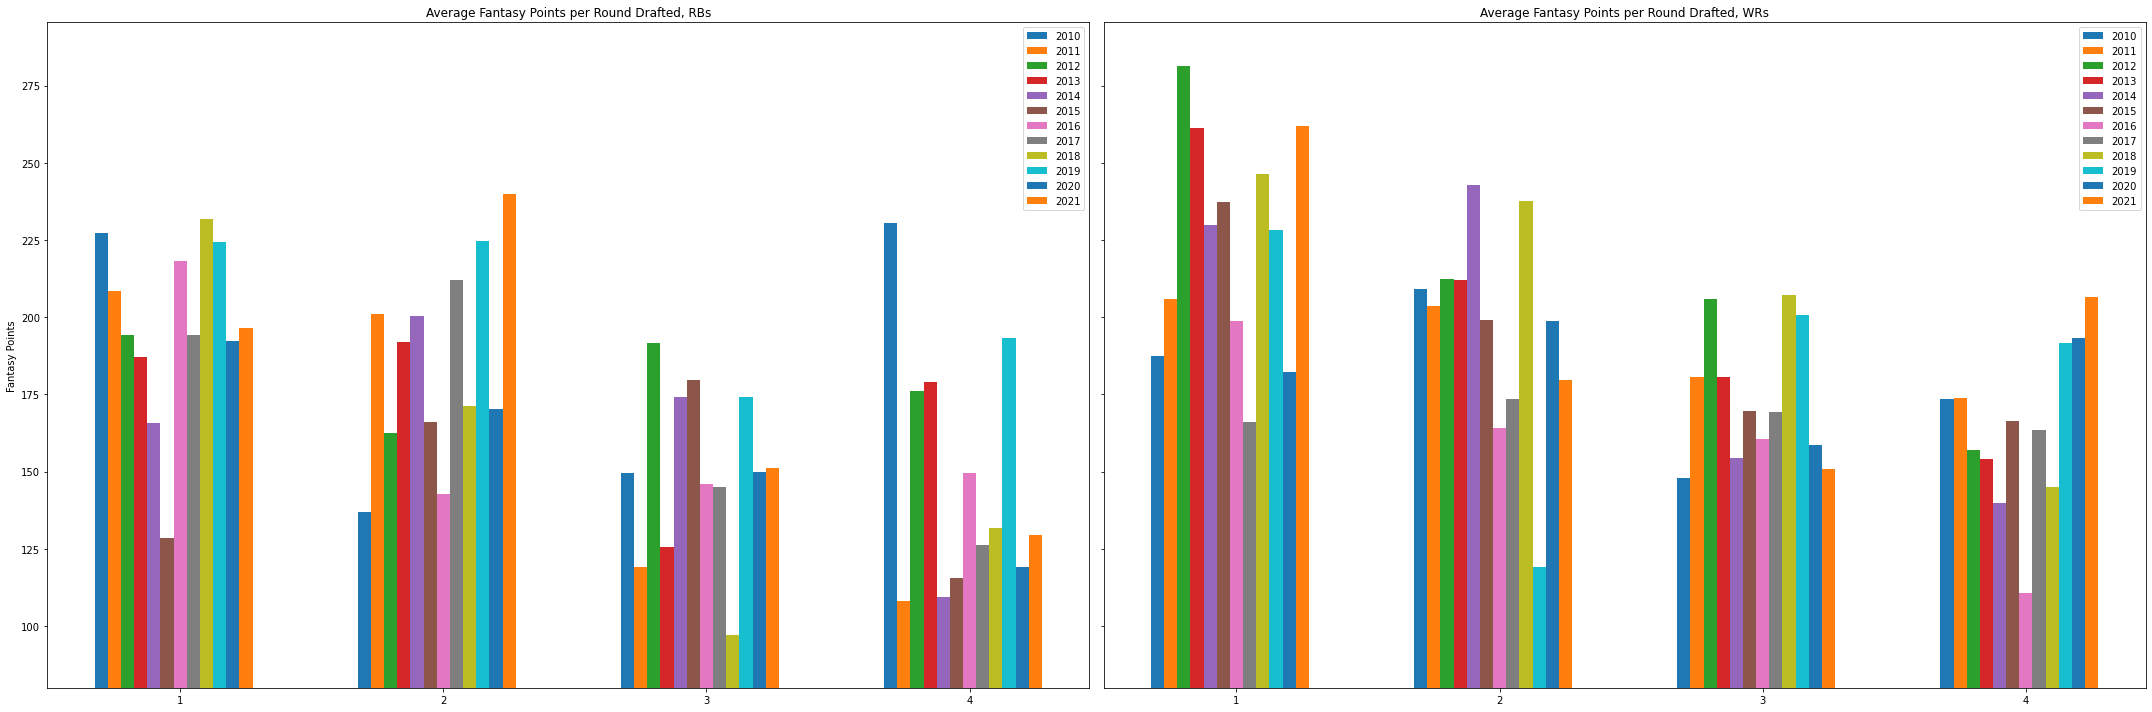

In [32]:
labels = range(1, 5)
x = np.arange(len(labels))
width = 0.05

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(30,10))

for i, season in enumerate(seasons):
    rb_data = [r for r in rb_group.loc[season]["FantPt"]]
    wr_data = [w for w in wr_group.loc[season]["FantPt"]]
    ax1.bar(x + 2*(i - 6) * width/2, rb_data, width, label=str(season))
    ax2.bar(x + 2*(i - 6) * width/2, wr_data, width, label=str(season))
    
ax1.set_ylabel('Fantasy Points')
ax1.set_title('Average Fantasy Points per Round Drafted, RBs')
ax2.set_title('Average Fantasy Points per Round Drafted, WRs')
ax1.set_xticks(x, labels)
ax2.set_xticks(x, labels)
ax1.set_ylim(80)
ax2.set_ylim(80)
ax1.legend()
ax2.legend()

fig.tight_layout()

plt.show()

There's a large amount of variance, to be expected, but no clear answers. Let's take the mean of each round across seasons, and investigate

In [33]:
total_rd_rb = first_4_joined[first_4_joined["position"] == "RB"].groupby("rd").agg({"FantPt": "mean"})
total_rd_wr = first_4_joined[first_4_joined["position"] == "WR"].groupby("rd").agg({"FantPt": "mean"})

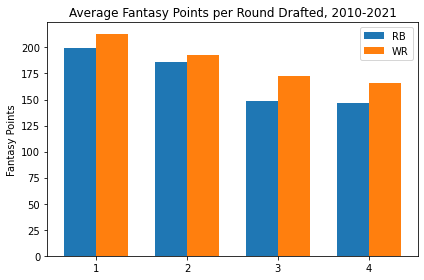

In [34]:
labels = range(1,5)
x = np.arange(len(labels))
width = 0.35

total_rb_data = [r for r in total_rd_rb['FantPt']]
total_wr_data = [w for w in total_rd_wr['FantPt']]

fig, ax = plt.subplots()
ax.bar(x - width/2, total_rb_data, width, label='RB')
ax.bar(x + width/2, total_wr_data, width, label='WR')

ax.set_ylabel('Fantasy Points')
ax.set_title('Average Fantasy Points per Round Drafted, 2010-2021')
ax.set_xticks(x, labels)


ax.legend()

fig.tight_layout()

plt.show()

From the graph above, we can see that in rounds 1, 2 and 4, RBs provide on average slightly higher scoring totals than WRs, and only slightly less than WRs in the 3rd round.

Only taking this information into consideration, it would be easy to conclude that taking early round running backs is still the best strategy. However, just looking at fantasy points won't give us the whole picture. 

For instance, if we were to draft solely based on fantasy point totals, we would draft a QB in the first round, as QBs have a higher average fantasy point production than any other position. However, due to the depth available at the QB position (among other factors), QBs are often only drafted from the 2nd round onwards. By drafting a QB in the 1st round, we lose the opportunity to draft an elite WR or RB in the same spot, and would have likely been able to draft that same QB in the 2nd round anyway.

In the same vein, the value of drafting a high quality RB in the 1st round is lessened by the quality of RBs available in the later rounds. Of course, this applies for any position.

What we're really interested in is value relative to other available players. Let's introduce the "Value Over" family of metrics: Value Over Average and Value Over Replacement.

# Value Defined

With the league settings defined earlier in this project, a 12-man fantasy football draft will result in the following picks:

- 24 QBs (1 starter and 1 bench per team)
- 48 RBs (2 starters and 2 bench per team)
- 48 WRs (2 starters and 2 bench per team)
- 24 TEs (1 starter and 1 bench per team)

To calculate Value Over Average for each player, we'll calculate the average fantasy point production for the top 48 RBs and the top 48 WRs by scoring, and then compare each player's fantasy point production to the average at their position.

Value Over Replacement uses a similar process to the above, but instead compares a player's to that of a "replacement-level player" that lands outside of the top 48 RBs and the top 48 WRs.

In [35]:
positions = {"WR": 48, "RB": 48}
g = joined.groupby(["Season", "position"]).apply(lambda x: x.sort_values(["FantPt"], ascending=False)).reset_index(drop=True)


In [36]:
g

,player_id,Name,position,team,adp,adp_formatted,times_drafted,high,low,stdev,bye,Season,FantPt,gp,rd
0,1004,AaronRodgers,QB,GB,7.8,1.08,344,1,17,2.6,14.0,2010,315.4,15.0,1.0
1,750,PeytonManning,QB,IND,20.6,2.09,371,9,34,4.4,14.0,2010,303.0,16.0,2.0
2,119,TomBrady,QB,NE,26.9,3.03,366,10,44,6.1,10.0,2010,303.0,16.0,3.0
3,995,PhilipRivers,QB,LAC,47.9,4.12,268,27,74,8.0,8.0,2010,294.4,16.0,4.0
4,127,DrewBrees,QB,NO,13.2,2.01,368,3,24,3.8,14.0,2010,291.7,16.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,5183,TerraceMarshallJr,WR,CAR,149.0,13.05,276,106,179,16.4,13.0,2021,0.0,0.0,13.0
1960,2912,DJChark,WR,JAX,112.8,10.05,521,92,130,7.9,11.0,2021,0.0,0.0,10.0
1961,2523,RobbyAnderson,WR,CAR,75.0,7.03,972,59,91,5.8,13.0,2021,0.0,0.0,7.0
1962,2483,TyrellWilliams,WR,DET,160.0,14.04,42,130,207,21.3,6.0,2021,0.0,0.0,14.0


In [37]:
g = g.groupby(["position", "Season"]).head(49)

In [38]:
for season in seasons:
    for position in positions.keys():
        print(season, position)
        print(len(g[(g["position"] == position) & (g["Season"] == season)]))

2010 WR
49
2010 RB
49
2011 WR
49
2011 RB
49
2012 WR
36
2012 RB
33
2013 WR
49
2013 RB
49
2014 WR
49
2014 RB
49
2015 WR
49
2015 RB
49
2016 WR
49
2016 RB
49
2017 WR
49
2017 RB
49
2018 WR
49
2018 RB
49
2019 WR
49
2019 RB
49
2020 WR
49
2020 RB
49
2021 WR
49
2021 RB
49


It's clear that the data from 2012 isn't complete. We'll omit this year from our analysis.

In [39]:
seasons = np.delete(seasons, np.where(seasons == 2012))
for season in seasons:
    for position in positions.keys():
        m = positions[position]
        n = g.columns.get_loc("FantPt")
        avg = g[(g["position"] == position) & (g["Season"] == season)].head(m)["FantPt"].mean()
        replacement = g[(g["position"] == position) & (g["Season"] == season)].iat[m, n]
        g.loc[(g["position"] == position) & (g["Season"] == season), "avg"] = avg
        g.loc[(g["position"] == position) & (g["Season"] == season), "replacement"] = replacement
        

In [40]:
g.loc[:,"voa"] = g["FantPt"] - g["avg"]
g.loc[:, "vor"] = g["FantPt"] - g["replacement"]

In [41]:
g["voa"].describe()

count    1078.000000
mean       -1.838088
std        61.908376
min      -111.706250
25%       -49.502083
50%        -9.834375
75%        36.661979
max       245.970833
Name: voa, dtype: float64

In [42]:
g["vor"].describe()

count    1078.000000
mean       88.228200
std        63.421948
min         0.000000
25%        38.125000
50%        78.600000
75%       125.725000
max       349.800000
Name: vor, dtype: float64

Now that we've calculated a more useful metric, we'll repeat the same visualization we did above using VOR and VOA, examining the first 6 rounds of the draft:

In [43]:
first_6_rounds = g[g["rd"] <= 6]

In [44]:
first_6_rounds[first_6_rounds["position"] == "RB"]

,player_id,Name,position,team,adp,adp_formatted,times_drafted,high,low,stdev,bye,Season,FantPt,gp,rd,avg,replacement,voa,vor
29,1724,ArianFoster,RB,HOU,38.2,4.02,544,21,57,6.5,6.0,2010,359.0,16.0,4.0,151.356250,45.4,207.643750,313.6
31,1368,JamaalCharles,RB,KC,24.9,3.01,342,10,42,6.1,8.0,2010,260.0,16.0,3.0,151.356250,45.4,108.643750,214.6
32,1645,LeSeanMcCoy,RB,PHI,35.3,3.11,383,22,48,4.8,7.0,2010,258.2,15.0,3.0,151.356250,45.4,106.843750,212.8
33,925,AdrianPeterson,RB,MIN,2.3,1.02,342,1,23,1.3,7.0,2010,257.9,15.0,1.0,151.356250,45.4,106.543750,212.5
34,1347,ChrisJohnson,RB,TEN,1.4,1.01,422,1,24,1.3,6.0,2010,250.9,16.0,1.0,151.356250,45.4,99.543750,205.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,2309,MikeDavis,RB,ATL,43.1,4.07,1311,29,66,5.2,14.0,2021,116.2,17.0,4.0,161.466667,75.2,-45.266667,41.0
1843,2434,ChristianMcCaffrey,RB,CAR,1.2,1.01,1368,1,5,0.5,13.0,2021,109.0,7.0,1.0,161.466667,75.2,-52.466667,33.8
1844,4889,ClydeEdwardsHelaire,RB,KC,20.4,2.08,1255,14,30,2.3,8.0,2021,108.1,10.0,2.0,161.466667,75.2,-53.366667,32.9
1849,3252,MilesSanders,RB,PHI,38.7,4.03,789,27,49,4.4,7.0,2021,104.2,12.0,4.0,161.466667,75.2,-57.266667,29.0


In [45]:
first_6_rb_group = first_6_rounds[first_6_rounds["position"] == "RB"].groupby(["Season", "rd"])
first_6_wr_group = first_6_rounds[first_6_rounds["position"] == "WR"].groupby(["Season", "rd"])

In [46]:
rb_value = first_6_rb_group.agg({"vor": 'mean', "voa": "mean"})
wr_value = first_6_wr_group.agg({"vor": 'mean', "voa": "mean"})

In [47]:
rb_value

vor        voa
Season rd                        
2010   1.0  181.814286  75.858036
       2.0   91.433333 -14.522917
       3.0  129.000000  23.043750
       4.0  185.100000  79.143750
       5.0   63.120000 -42.836250
...                ...        ...
2021   1.0  121.200000  34.933333
       2.0  164.780000  78.513333
       3.0  102.375000  16.108333
       4.0   54.400000 -31.866667
       5.0   76.125000 -10.141667

[71 rows x 2 columns]

Now, we'll plot each player's ADP vs their VOR & VOA

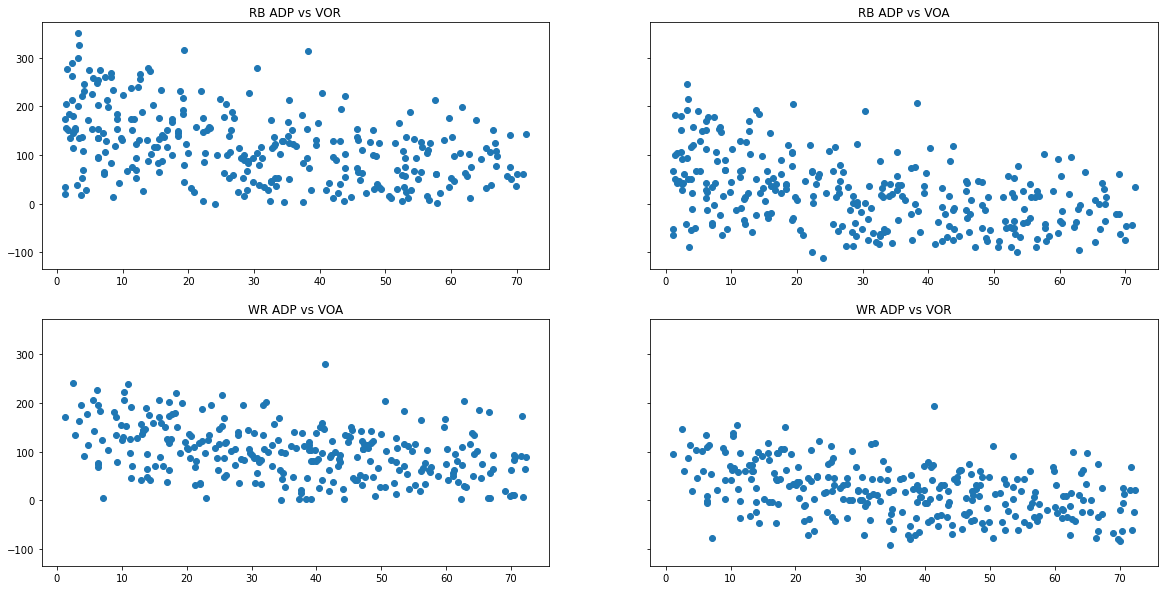

In [48]:
first_6_rb = first_6_rounds[first_6_rounds["position"] == "RB"]
first_6_wr = first_6_rounds[first_6_rounds["position"] == "WR"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(20, 10))
ax1.scatter(first_6_rb["adp"], first_6_rb["vor"])
ax1.set_title("RB ADP vs VOR")

ax2.scatter(first_6_rb["adp"], first_6_rb["voa"])
ax2.set_title("RB ADP vs VOA")

ax3.scatter(first_6_wr["adp"], first_6_wr["vor"])
ax3.set_title("WR ADP vs VOA")

ax4.scatter(first_6_wr["adp"], first_6_wr["voa"])
ax4.set_title("WR ADP vs VOR")

plt.show()

Again, we can see that the distribution of WR Value is tighter than that of RB Value, showing both higher floors and lower ceilings.

In [49]:
rb_value.groupby("rd").agg({'vor': "mean", "voa": "mean"})

,vor,voa
rd,,
1.0,165.285036,66.714392
2.0,141.557576,42.986932
3.0,101.967511,3.396867
4.0,101.877662,3.307018
5.0,76.626364,-21.944280
6.0,86.195000,-13.606042


In [50]:
wr_value.groupby("rd").agg({'vor': "mean", "voa": "mean"})

,vor,voa
rd,,
1.0,154.939545,73.377614
2.0,119.416667,37.854735
3.0,101.809848,20.247917
4.0,88.001970,6.440038
5.0,82.091061,0.529129
6.0,73.532727,-8.029205


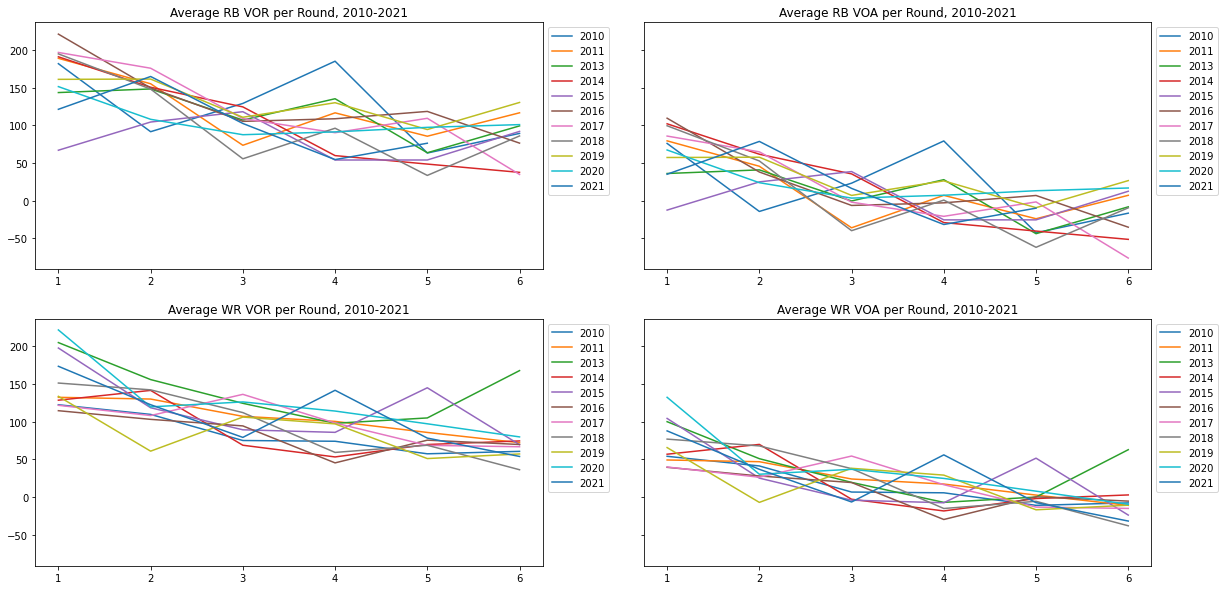

In [51]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(20, 10))
for season in seasons:
    ax1.plot(rb_value.xs(season)["vor"], label=str(season))
    ax1.set_title("Average RB VOR per Round, 2010-2021")
    ax1.legend(bbox_to_anchor=(1.0, 1.0))
    ax2.plot(rb_value.xs(season)["voa"], label=str(season))
    ax2.set_title("Average RB VOA per Round, 2010-2021")
    ax2.legend(bbox_to_anchor=(1.0, 1.0))
    ax3.plot(wr_value.xs(season)["vor"], label=str(season))
    ax3.set_title("Average WR VOR per Round, 2010-2021")
    ax3.legend(bbox_to_anchor=(1.0, 1.0))
    ax4.plot(wr_value.xs(season)["voa"], label=str(season))
    ax4.legend(bbox_to_anchor=(1.0, 1.0))
    ax4.set_title("Average WR VOA per Round, 2010-2021")

# Winning is Everything

We've only talked about value in terms of points so far. However, in fantasy football, what matters most are wins. In order to measure an individual player's contribution to a weekly win, we have to take the following steps:
1. Calculate the average fantasy team's scoring total, along with standard deviation, per week
2. Calculate the average fantasy team's scoring total WITH individual player's contribution per week
3. Calculate the percent chance that a fantasy team scores less than the total found in step 2
4. Average the percentages to find an overall win percentage
5. Multiply by the number of games in the season to obtain a player's total wins above average

In [52]:
positions = {"QB": 12, "RB": 24, "WR": 24, "TE": 12}
pos_avg = joined.groupby(["Season", "position"]).apply(lambda x: x.sort_values("FantPt", ascending=False)).reset_index(drop=True)


In [53]:
qb_te = pos_avg[pos_avg["position"].isin(["QB", "TE"])].groupby(["Season", "position"]).head(12).groupby(["Season", "position"]).agg({"FantPt": ["mean", "std"]})
rb_wr = pos_avg[pos_avg["position"].isin(["WR", "RB"])].groupby(["Season", "position"]).head(24).groupby(["Season", "position"]).agg({"FantPt": ["mean", "std"]})

In [54]:
qb_te_names = pos_avg[pos_avg["position"].isin(["QB", "TE"]) & (pos_avg["Season"] == 2010)].groupby(["Season", "position"]).head(12)["Name"]
rb_wr_names = pos_avg[pos_avg["position"].isin(["RB", "WR"]) & (pos_avg["Season"] == 2010)].groupby(["Season", "position"]).head(24)["Name"]
names = pd.concat([qb_te_names, rb_wr_names])
players[(players["Name"].isin(names)) & (players["Season"] == 2010)].groupby(["Season", "G#", "Position"]).agg({"FantPt": "mean"})

FantPt
Season G# Position           
2010   1  QB        15.900000
          RB        14.773913
          TE         6.661538
          WR        11.550000
       2  QB        15.958333
...                       ...
       15 WR        11.804545
       16 QB        12.236364
          RB        11.705263
          TE        10.600000
          WR        11.931250

[64 rows x 1 columns]

In [55]:
weekly_qb_te = qb_te / 16
weekly_rb_wr = rb_wr / 16

In [56]:
weekly_pos_avg = pd.concat([weekly_qb_te, weekly_rb_wr], axis=0).reset_index(level=(0,1))
weekly_pos_avg.columns = ["Season", "position", "mean", "std"]

In [57]:
weekly_pos_avg = weekly_pos_avg.sort_values(["Season", "position"]).reset_index(drop=True)

In [58]:
weekly_pos_avg

,Season,position,mean,std
0,2010,QB,16.916146,1.810711
1,2010,RB,13.364583,3.209204
2,2010,TE,8.647917,2.000597
3,2010,WR,12.872396,2.672734
4,2011,QB,19.868750,4.021554
5,2011,RB,13.073958,2.938425
6,2011,TE,10.676563,2.921210
7,2011,WR,12.332292,2.460739
8,2012,QB,19.226562,2.726488
9,2012,RB,10.495833,3.993588


In [59]:
weekly_pos_avg = weekly_pos_avg.rename({"position":"Position","mean":"pos_mean"}, axis=1)

In [60]:
weekly_pos_avg

,Season,Position,pos_mean,std
0,2010,QB,16.916146,1.810711
1,2010,RB,13.364583,3.209204
2,2010,TE,8.647917,2.000597
3,2010,WR,12.872396,2.672734
4,2011,QB,19.868750,4.021554
5,2011,RB,13.073958,2.938425
6,2011,TE,10.676563,2.921210
7,2011,WR,12.332292,2.460739
8,2012,QB,19.226562,2.726488
9,2012,RB,10.495833,3.993588


In [61]:
players

,G#,Date,Tm,Away,Opp,FantPt,Name,Position,Season,gp
0,1,2010-09-12,HOU,0,IND,42.3,ArianFoster,RB,2010,0
1,2,2010-09-19,HOU,1,WAS,15.3,ArianFoster,RB,2010,0
2,3,2010-09-26,HOU,0,DAL,12.6,ArianFoster,RB,2010,0
3,4,2010-10-03,HOU,1,OAK,32.4,ArianFoster,RB,2010,0
4,5,2010-10-10,HOU,0,NYG,3.7,ArianFoster,RB,2010,0
...,...,...,...,...,...,...,...,...,...,...
47508,11,2021-11-28,HOU,0,NYJ,0.1,ChrisMoore,WR,2021,0
47509,12,2021-12-05,HOU,0,IND,NaN,ChrisMoore,WR,2021,0
47510,14,2021-12-19,HOU,1,JAX,NaN,ChrisMoore,WR,2021,0
47511,15,2021-12-26,HOU,0,LAC,6.0,ChrisMoore,WR,2021,0


In [62]:
players = players.rename({"G#":"week"}, axis=1)

In [63]:
def top_12_teams(df):
"""
Calculates the average team score and stdev of those scores for each week of the season.
Returns a dataframe of the mean scores and stdev, by week and season.
"""
    dfs = []
    df = df.groupby(["Season", "week", "Position"]).apply(lambda x: x.sort_values("FantPt", ascending=False))[["Name", "Season", "FantPt"]]
    for season in range(2010, 2022):
        qb_te_names = pos_avg[pos_avg["position"].isin(["QB", "TE"]) & (pos_avg["Season"] == season)].groupby(["Season", "position"]).head(12)["Name"]
        rb_wr_names = pos_avg[pos_avg["position"].isin(["RB", "WR"]) & (pos_avg["Season"] == season)].groupby(["Season", "position"]).head(24)["Name"]
        names = pd.concat([qb_te_names, rb_wr_names])
        mean_std_df = df[(df["Name"].isin(names))].loc[season].groupby(["week", "Position"]).agg({"FantPt": ("mean", "std")})
        print(mean_std_df)
        weekly = pd.DataFrame(columns=["Season", "week", "mean", "std"])
        for week in mean_std_df.index.get_level_values("week").unique():
            weekly.loc[week, "Season"] = season
            weekly.loc[week, "mean"] = mean_std_df.loc[(week, "QB"), ("FantPt", "mean")] + mean_std_df.loc[(week, "TE"), ("FantPt", "mean")] + 2*mean_std_df.loc[(week, "RB"), ("FantPt", "mean")] + 2*mean_std_df.loc[(week, "WR"), ("FantPt", "mean")]
            weekly.loc[week, "std"] = ((mean_std_df.loc[(week, "QB"), ("FantPt", "std")])**2 + (mean_std_df.loc[(week, "TE"), ("FantPt", "std")])**2 + 2*(mean_std_df.loc[(week, "RB"), ("FantPt", "std")])**2 + 2*(mean_std_df.loc[(week, "WR"), ("FantPt", "std")])**2)**(1/2)
            weekly.loc[week, "week"] = week
        dfs.append(weekly)
    return pd.concat(dfs)

In [64]:
players = players.merge(top_12_teams(players), on=["Season", "week"], how="left")

                  FantPt          
                    mean       std
week Position                     
1    QB        15.900000  7.308028
     RB        14.773913  9.706803
     TE         6.661538  4.473727
     WR        11.550000  7.082188
2    QB        15.958333  8.785262
...                  ...       ...
15   WR        11.804545  7.001869
16   QB        12.236364  5.205242
     RB        11.705263  8.156965
     TE        10.600000  5.991899
     WR        11.931250  5.665300

[64 rows x 2 columns]
                  FantPt           
                    mean        std
week Position                      
1    QB        21.666667   8.125866
     RB        13.439130   8.384116
     TE        11.150000   5.053082
     WR        12.850000   7.044332
2    QB        21.466667   5.184826
...                  ...        ...
15   WR        13.854545   7.221577
16   QB        21.572727  10.083758
     RB        13.781250   8.442213
     TE        16.058333   6.854257
     WR        15.0

In [65]:
players

,week,Date,Tm,Away,Opp,FantPt,Name,Position,Season,gp,mean,std
0,1,2010-09-12,HOU,0,IND,42.3,ArianFoster,RB,2010,0,75.209365,19.031036
1,2,2010-09-19,HOU,1,WAS,15.3,ArianFoster,RB,2010,0,77.55392,20.997893
2,3,2010-09-26,HOU,0,DAL,12.6,ArianFoster,RB,2010,0,84.201394,20.116983
3,4,2010-10-03,HOU,1,OAK,32.4,ArianFoster,RB,2010,0,80.955369,20.381183
4,5,2010-10-10,HOU,0,NYG,3.7,ArianFoster,RB,2010,0,81.632811,16.186797
...,...,...,...,...,...,...,...,...,...,...,...,...
47508,11,2021-11-28,HOU,0,NYJ,0.1,ChrisMoore,WR,2021,0,86.133785,22.527161
47509,12,2021-12-05,HOU,0,IND,NaN,ChrisMoore,WR,2021,0,83.745099,19.918932
47510,14,2021-12-19,HOU,1,JAX,NaN,ChrisMoore,WR,2021,0,77.006602,19.2072
47511,15,2021-12-26,HOU,0,LAC,6.0,ChrisMoore,WR,2021,0,82.463333,20.327314


In [66]:
players = players.merge(weekly_pos_avg[["Position", "Season", "pos_mean"]], how="left", on=["Position", "Season"])

In [67]:
players["FantPt"] = players["FantPt"].fillna(0)

In [68]:
players = players.dropna()

In [69]:
players["mean_inclusive"] = players["mean"] - players["pos_mean"] + players["FantPt"]

In [70]:
players

,week,Date,Tm,Away,Opp,FantPt,Name,Position,Season,gp,mean,std,pos_mean,mean_inclusive
0,1,2010-09-12,HOU,0,IND,42.3,ArianFoster,RB,2010,0,75.209365,19.031036,13.364583,104.144781
1,2,2010-09-19,HOU,1,WAS,15.3,ArianFoster,RB,2010,0,77.55392,20.997893,13.364583,79.489336
2,3,2010-09-26,HOU,0,DAL,12.6,ArianFoster,RB,2010,0,84.201394,20.116983,13.364583,83.43681
3,4,2010-10-03,HOU,1,OAK,32.4,ArianFoster,RB,2010,0,80.955369,20.381183,13.364583,99.990786
4,5,2010-10-10,HOU,0,NYG,3.7,ArianFoster,RB,2010,0,81.632811,16.186797,13.364583,71.968228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47508,11,2021-11-28,HOU,0,NYJ,0.1,ChrisMoore,WR,2021,0,86.133785,22.527161,13.775000,72.458785
47509,12,2021-12-05,HOU,0,IND,0.0,ChrisMoore,WR,2021,0,83.745099,19.918932,13.775000,69.970099
47510,14,2021-12-19,HOU,1,JAX,0.0,ChrisMoore,WR,2021,0,77.006602,19.2072,13.775000,63.231602
47511,15,2021-12-26,HOU,0,LAC,6.0,ChrisMoore,WR,2021,0,82.463333,20.327314,13.775000,74.688333


In [71]:
from scipy.stats import norm

In [72]:
players["zscore"] = (players["mean_inclusive"] - players["mean"]) / players["std"]

In [73]:
players["waa"] = norm.cdf(players["zscore"].to_numpy(dtype="float"))

In [74]:
players

,week,Date,Tm,Away,Opp,FantPt,Name,Position,Season,gp,mean,std,pos_mean,mean_inclusive,zscore,waa
0,1,2010-09-12,HOU,0,IND,42.3,ArianFoster,RB,2010,0,75.209365,19.031036,13.364583,104.144781,1.520433,0.935799
1,2,2010-09-19,HOU,1,WAS,15.3,ArianFoster,RB,2010,0,77.55392,20.997893,13.364583,79.489336,0.092172,0.536719
2,3,2010-09-26,HOU,0,DAL,12.6,ArianFoster,RB,2010,0,84.201394,20.116983,13.364583,83.43681,-0.038007,0.484841
3,4,2010-10-03,HOU,1,OAK,32.4,ArianFoster,RB,2010,0,80.955369,20.381183,13.364583,99.990786,0.93397,0.824840
4,5,2010-10-10,HOU,0,NYG,3.7,ArianFoster,RB,2010,0,81.632811,16.186797,13.364583,71.968228,-0.597066,0.275232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47508,11,2021-11-28,HOU,0,NYJ,0.1,ChrisMoore,WR,2021,0,86.133785,22.527161,13.775000,72.458785,-0.607045,0.271911
47509,12,2021-12-05,HOU,0,IND,0.0,ChrisMoore,WR,2021,0,83.745099,19.918932,13.775000,69.970099,-0.691553,0.244609
47510,14,2021-12-19,HOU,1,JAX,0.0,ChrisMoore,WR,2021,0,77.006602,19.2072,13.775000,63.231602,-0.717179,0.236632
47511,15,2021-12-26,HOU,0,LAC,6.0,ChrisMoore,WR,2021,0,82.463333,20.327314,13.775000,74.688333,-0.38249,0.351049


In [75]:
players.sort_values(["Season", "waa"], ascending=False)

,week,Date,Tm,Away,Opp,FantPt,Name,Position,Season,gp,mean,std,pos_mean,mean_inclusive,zscore,waa
43593,16,2022-01-02,CIN,0,KAN,50.1,JaMarrChase,WR,2021,0,87.058441,20.532023,13.775000,123.383441,1.769188,0.961569
43454,11,2021-11-21,IND,1,BUF,51.9,JonathanTaylor,RB,2021,0,86.133785,22.527161,13.089844,124.943941,1.722816,0.957539
44135,2,2021-09-19,TEN,1,SEA,44.7,DerrickHenry,RB,2021,0,84.861232,19.944422,13.089844,116.471388,1.584912,0.943507
43744,4,2021-10-03,KAN,1,PHI,42.1,TyreekHill,WR,2021,0,85.025395,18.995907,13.775000,113.350395,1.491111,0.932034
43702,9,2021-11-07,ARI,1,SFO,37.8,JamesConner,RB,2021,0,81.553636,16.992962,13.089844,106.263793,1.454141,0.927046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,5,2010-10-10,DET,0,STL,0.1,DrewStanton,QB,2010,0,81.632811,16.186797,16.916146,64.816666,-1.03888,0.149430
1771,12,2010-12-05,MIN,0,BUF,-1.0,BrettFavre,QB,2010,0,81.955254,17.191835,16.916146,64.039109,-1.042131,0.148675
1248,16,2011-01-02,NYJ,0,BUF,0.0,MarkSanchez,QB,2010,0,70.10939,16.132601,16.916146,53.193244,-1.048569,0.147188
3251,16,2011-01-02,CLE,0,PIT,0.0,SenecaWallace,QB,2010,0,70.10939,16.132601,16.916146,53.193244,-1.048569,0.147188


In [76]:
players.groupby(["Season","Position","Name"]).agg({"waa": "sum"})

waa
Season Position Name                       
2010   QB       AaronRodgers       8.739562
                AlexSmith          4.668483
                BenRoethlisberger  6.248057
                BrettFavre         4.486676
                BruceGradkowski    2.110741
...                                     ...
2021   WR       TylerLockett       7.691775
                TyreekHill         8.483539
                VanJefferson       6.667610
                ZachPascal         5.124069
                ZayJones           5.441780

[3472 rows x 1 columns]

In [77]:
players_adp = players.merge(first_6_rounds[["Name", "Season", "adp"]], on=["Name", "Season"], how="left").dropna()

In [78]:
players_adp

,week,Date,Tm,Away,Opp,FantPt,Name,Position,Season,gp,mean,std,pos_mean,mean_inclusive,zscore,waa,adp
0,1,2010-09-12,HOU,0,IND,42.3,ArianFoster,RB,2010,0,75.209365,19.031036,13.364583,104.144781,1.520433,0.935799,38.2
1,2,2010-09-19,HOU,1,WAS,15.3,ArianFoster,RB,2010,0,77.55392,20.997893,13.364583,79.489336,0.092172,0.536719,38.2
2,3,2010-09-26,HOU,0,DAL,12.6,ArianFoster,RB,2010,0,84.201394,20.116983,13.364583,83.43681,-0.038007,0.484841,38.2
3,4,2010-10-03,HOU,1,OAK,32.4,ArianFoster,RB,2010,0,80.955369,20.381183,13.364583,99.990786,0.93397,0.824840,38.2
4,5,2010-10-10,HOU,0,NYG,3.7,ArianFoster,RB,2010,0,81.632811,16.186797,13.364583,71.968228,-0.597066,0.275232,38.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47375,2,2021-09-16,WAS,0,NYG,7.0,LoganThomas,TE,2021,0,84.861232,19.944422,9.504688,82.356544,-0.125583,0.450031,72.2
47376,3,2021-09-26,WAS,1,BUF,10.2,LoganThomas,TE,2021,0,87.685606,16.716006,9.504688,88.380919,0.041596,0.516589,72.2
47377,4,2021-10-03,WAS,1,ATL,0.0,LoganThomas,TE,2021,0,85.025395,18.995907,9.504688,75.520708,-0.500355,0.308413,72.2
47378,11,2021-11-29,WAS,0,SEA,4.6,LoganThomas,TE,2021,0,86.133785,22.527161,9.504688,81.229098,-0.217723,0.413822,72.2


In [79]:
pag = players_adp.groupby(["Season", "Position", "Name"]).apply(lambda x: x.agg({"waa": "sum", "adp": "mean"}))

Let's take a look at the best fantasy seasons of all time, according to WAA:

In [80]:
pag.sort_values("waa", ascending=False).head(20)

,,,waa,adp
Season,Position,Name,,
2019,RB,ChristianMcCaffrey,11.313433,3.2
2021,WR,CooperKupp,11.132586,41.3
2016,RB,DavidJohnson,11.043990,3.4
2021,RB,JonathanTaylor,10.710055,13.8
2010,RB,ArianFoster,10.662885,38.2
2014,RB,DeMarcoMurray,10.556044,14.2
2012,RB,ArianFoster,10.422189,1.4
2014,RB,LeVeonBell,10.411396,30.4
2017,RB,ToddGurley,10.395466,19.4


13 of the top 20 best fantasy players from 2010-2021 in wins above average have been accomplished by running backs.

In [81]:
pag = pag.reset_index()

# WAA: What is it good for?

We've finally obtained a comprehensive dataset with the metric we've been looking for this entire time, WAA. Let's start by splitting it up by ADP, and plot WAA vs adp along with the mean for each round of the draft.

In [82]:
round_1_rb = pag[(pag["Position"] == "RB") & (pag["adp"] < 12.5)]
round_2_rb = pag[(pag["Position"] == "RB") & (pag["adp"] >= 12.5) & (pag["adp"] < 24.5)]
round_3_rb = pag[(pag["Position"] == "RB") & (pag["adp"] >= 24.5) & (pag["adp"] < 36.5)]
round_4_rb = pag[(pag["Position"] == "RB") & (pag["adp"] >= 36.5) & (pag["adp"] < 48.5)]
round_5_rb = pag[(pag["Position"] == "RB") & (pag["adp"] >= 48.5) & (pag["adp"] < 60.5)]
round_6_rb = pag[(pag["Position"] == "RB") & (pag["adp"] >= 60.5)]

round_1_wr = pag[(pag["Position"] == "WR") & (pag["adp"] < 12.5)]
round_2_wr = pag[(pag["Position"] == "WR") & (pag["adp"] >= 12.5) & (pag["adp"] < 24.5)]
round_3_wr = pag[(pag["Position"] == "WR") & (pag["adp"] >= 24.5) & (pag["adp"] < 36.5)]
round_4_wr = pag[(pag["Position"] == "WR") & (pag["adp"] >= 36.5) & (pag["adp"] < 48.5)]
round_5_wr = pag[(pag["Position"] == "WR") & (pag["adp"] >= 48.5) & (pag["adp"] < 60.5)]
round_6_wr = pag[(pag["Position"] == "WR") & (pag["adp"] >= 60.5)]

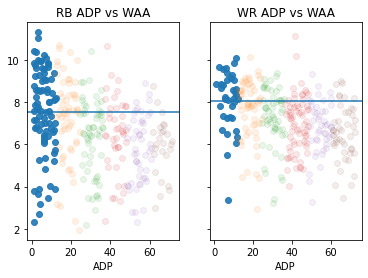

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(40, 20)

ax1.scatter(round_1_rb["adp"], round_1_rb["waa"], alpha=.9)
ax1.scatter(round_2_rb["adp"], round_2_rb["waa"], alpha=.1)
ax1.scatter(round_3_rb["adp"], round_3_rb["waa"], alpha=.1)
ax1.scatter(round_4_rb["adp"], round_4_rb["waa"], alpha=.1)
ax1.scatter(round_5_rb["adp"], round_5_rb["waa"], alpha=.1)
ax1.scatter(round_6_rb["adp"], round_6_rb["waa"], alpha=.1)
ax1.axhline(round_1_rb["waa"].mean(), color="C0")
ax1.set_title("RB ADP vs WAA")
ax1.set_xlabel("ADP")

ax2.scatter(round_1_wr["adp"], round_1_wr["waa"], alpha=.9)
ax2.scatter(round_2_wr["adp"], round_2_wr["waa"], alpha=.1)
ax2.scatter(round_3_wr["adp"], round_3_wr["waa"], alpha=.1)
ax2.scatter(round_4_wr["adp"], round_4_wr["waa"], alpha=.1)
ax2.scatter(round_5_wr["adp"], round_5_wr["waa"], alpha=.1)
ax2.scatter(round_6_wr["adp"], round_6_wr["waa"], alpha=.1)
ax2.axhline(round_1_wr["waa"].mean(), color="C0")
ax2.set_title("WR ADP vs WAA")
ax2.set_xlabel("ADP")

plt.show()

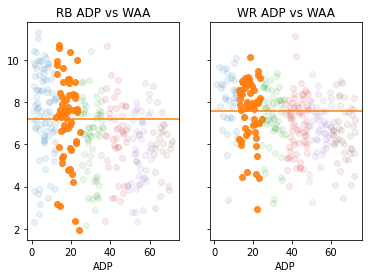

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(40, 20)

ax1.scatter(round_1_rb["adp"], round_1_rb["waa"], alpha=.1)
ax1.scatter(round_2_rb["adp"], round_2_rb["waa"], alpha=.9)
ax1.scatter(round_3_rb["adp"], round_3_rb["waa"], alpha=.1)
ax1.scatter(round_4_rb["adp"], round_4_rb["waa"], alpha=.1)
ax1.scatter(round_5_rb["adp"], round_5_rb["waa"], alpha=.1)
ax1.scatter(round_6_rb["adp"], round_6_rb["waa"], alpha=.1)
ax1.axhline(round_2_rb["waa"].mean(), color="C1")
ax1.set_title("RB ADP vs WAA")
ax1.set_xlabel("ADP")

ax2.scatter(round_1_wr["adp"], round_1_wr["waa"], alpha=.1)
ax2.scatter(round_2_wr["adp"], round_2_wr["waa"], alpha=.9)
ax2.scatter(round_3_wr["adp"], round_3_wr["waa"], alpha=.1)
ax2.scatter(round_4_wr["adp"], round_4_wr["waa"], alpha=.1)
ax2.scatter(round_5_wr["adp"], round_5_wr["waa"], alpha=.1)
ax2.scatter(round_6_wr["adp"], round_6_wr["waa"], alpha=.1)
ax2.axhline(round_2_wr["waa"].mean(), color="C1")
ax2.set_title("WR ADP vs WAA")
ax2.set_xlabel("ADP")

plt.show()

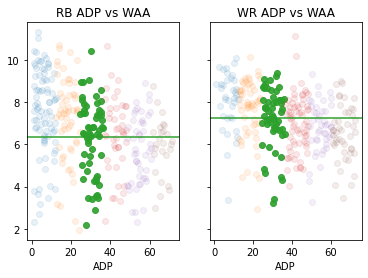

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(40, 20)

ax1.scatter(round_1_rb["adp"], round_1_rb["waa"], alpha=.1)
ax1.scatter(round_2_rb["adp"], round_2_rb["waa"], alpha=.1)
ax1.scatter(round_3_rb["adp"], round_3_rb["waa"], alpha=.9)
ax1.scatter(round_4_rb["adp"], round_4_rb["waa"], alpha=.1)
ax1.scatter(round_5_rb["adp"], round_5_rb["waa"], alpha=.1)
ax1.scatter(round_6_rb["adp"], round_6_rb["waa"], alpha=.1)
ax1.axhline(round_3_rb["waa"].mean(), color="C2")
ax1.set_title("RB ADP vs WAA")
ax1.set_xlabel("ADP")

ax2.scatter(round_1_wr["adp"], round_1_wr["waa"], alpha=.1)
ax2.scatter(round_2_wr["adp"], round_2_wr["waa"], alpha=.1)
ax2.scatter(round_3_wr["adp"], round_3_wr["waa"], alpha=.9)
ax2.scatter(round_4_wr["adp"], round_4_wr["waa"], alpha=.1)
ax2.scatter(round_5_wr["adp"], round_5_wr["waa"], alpha=.1)
ax2.scatter(round_6_wr["adp"], round_6_wr["waa"], alpha=.1)
ax2.axhline(round_3_wr["waa"].mean(), color="C2")
ax2.set_title("WR ADP vs WAA")
ax2.set_xlabel("ADP")

plt.show()

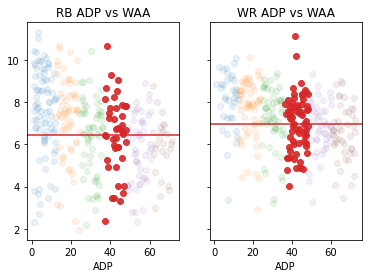

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(40, 20)

ax1.scatter(round_1_rb["adp"], round_1_rb["waa"], alpha=.1)
ax1.scatter(round_2_rb["adp"], round_2_rb["waa"], alpha=.1)
ax1.scatter(round_3_rb["adp"], round_3_rb["waa"], alpha=.1)
ax1.scatter(round_4_rb["adp"], round_4_rb["waa"], alpha=.9)
ax1.scatter(round_5_rb["adp"], round_5_rb["waa"], alpha=.1)
ax1.scatter(round_6_rb["adp"], round_6_rb["waa"], alpha=.1)
ax1.axhline(round_4_rb["waa"].mean(), color="C3")
ax1.set_title("RB ADP vs WAA")
ax1.set_xlabel("ADP")

ax2.scatter(round_1_wr["adp"], round_1_wr["waa"], alpha=.1)
ax2.scatter(round_2_wr["adp"], round_2_wr["waa"], alpha=.1)
ax2.scatter(round_3_wr["adp"], round_3_wr["waa"], alpha=.1)
ax2.scatter(round_4_wr["adp"], round_4_wr["waa"], alpha=.9)
ax2.scatter(round_5_wr["adp"], round_5_wr["waa"], alpha=.1)
ax2.scatter(round_6_wr["adp"], round_6_wr["waa"], alpha=.1)
ax2.axhline(round_4_wr["waa"].mean(), color="C3")
ax2.set_title("WR ADP vs WAA")
ax2.set_xlabel("ADP")

plt.show()

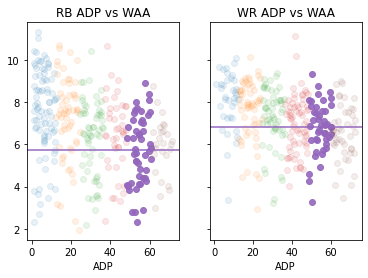

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(40, 20)

ax1.scatter(round_1_rb["adp"], round_1_rb["waa"], alpha=.1)
ax1.scatter(round_2_rb["adp"], round_2_rb["waa"], alpha=.1)
ax1.scatter(round_3_rb["adp"], round_3_rb["waa"], alpha=.1)
ax1.scatter(round_4_rb["adp"], round_4_rb["waa"], alpha=.1)
ax1.scatter(round_5_rb["adp"], round_5_rb["waa"], alpha=.9)
ax1.scatter(round_6_rb["adp"], round_6_rb["waa"], alpha=.1)
ax1.axhline(round_5_rb["waa"].mean(), color="C4")
ax1.set_title("RB ADP vs WAA")
ax1.set_xlabel("ADP")

ax2.scatter(round_1_wr["adp"], round_1_wr["waa"], alpha=.1)
ax2.scatter(round_2_wr["adp"], round_2_wr["waa"], alpha=.1)
ax2.scatter(round_3_wr["adp"], round_3_wr["waa"], alpha=.1)
ax2.scatter(round_4_wr["adp"], round_4_wr["waa"], alpha=.1)
ax2.scatter(round_5_wr["adp"], round_5_wr["waa"], alpha=.9)
ax2.scatter(round_6_wr["adp"], round_6_wr["waa"], alpha=.1)
ax2.axhline(round_5_wr["waa"].mean(), color="C4")
ax2.set_title("WR ADP vs WAA")
ax2.set_xlabel("ADP")

plt.show()

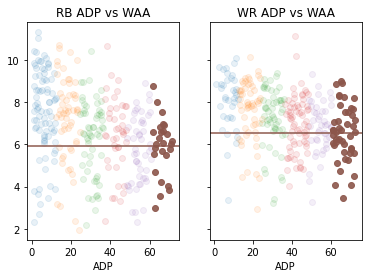

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.figsize=(40, 20)

ax1.scatter(round_1_rb["adp"], round_1_rb["waa"], alpha=.1)
ax1.scatter(round_2_rb["adp"], round_2_rb["waa"], alpha=.1)
ax1.scatter(round_3_rb["adp"], round_3_rb["waa"], alpha=.1)
ax1.scatter(round_4_rb["adp"], round_4_rb["waa"], alpha=.1)
ax1.scatter(round_5_rb["adp"], round_5_rb["waa"], alpha=.1)
ax1.scatter(round_6_rb["adp"], round_6_rb["waa"], alpha=.9)
ax1.axhline(round_6_rb["waa"].mean(), color="C5")
ax1.set_title("RB ADP vs WAA")
ax1.set_xlabel("ADP")

ax2.scatter(round_1_wr["adp"], round_1_wr["waa"], alpha=.1)
ax2.scatter(round_2_wr["adp"], round_2_wr["waa"], alpha=.1)
ax2.scatter(round_3_wr["adp"], round_3_wr["waa"], alpha=.1)
ax2.scatter(round_4_wr["adp"], round_4_wr["waa"], alpha=.1)
ax2.scatter(round_5_wr["adp"], round_5_wr["waa"], alpha=.1)
ax2.scatter(round_6_wr["adp"], round_6_wr["waa"], alpha=.9)
ax2.axhline(round_6_wr["waa"].mean(), color="C5")
ax2.set_title("WR ADP vs WAA")
ax2.set_xlabel("ADP")

plt.show()

Let's take a look at how many data points fall below the average in each round to measure the riskiness of drafting highly in each:

In [89]:
bins = [1, 12.5, 24.5, 36.5, 48.5, 60.5, 72.5]

rb_pag = pag[pag["Position"] == "RB"]
wr_pag = pag[pag["Position"] == "WR"]

In [90]:
rb_pag.groupby(pd.cut(rb_pag["adp"], bins, right=False)).agg({"waa": "mean"})

,waa
adp,
"[1.0, 12.5)",7.543941
"[12.5, 24.5)",7.222095
"[24.5, 36.5)",6.349986
"[36.5, 48.5)",6.450631
"[48.5, 60.5)",5.718982
"[60.5, 72.5)",5.905252


In [91]:
rb_pag.groupby(pd.cut(rb_pag["adp"], bins, right=False)).agg({"waa": "std"})

,waa
adp,
"[1.0, 12.5)",2.035929
"[12.5, 24.5)",1.982515
"[24.5, 36.5)",1.756557
"[36.5, 48.5)",1.778668
"[48.5, 60.5)",1.612947
"[60.5, 72.5)",1.374061


In [92]:
wr_pag.groupby(pd.cut(wr_pag["adp"], bins, right=False)).agg({"waa": "mean"})

,waa
adp,
"[1.0, 12.5)",8.069048
"[12.5, 24.5)",7.581504
"[24.5, 36.5)",7.251552
"[36.5, 48.5)",6.980198
"[48.5, 60.5)",6.812796
"[60.5, 72.5)",6.549450


In [93]:
wr_pag.groupby(pd.cut(wr_pag["adp"], bins, right=False)).agg({"waa": "std"})

,waa
adp,
"[1.0, 12.5)",1.384160
"[12.5, 24.5)",1.460999
"[24.5, 36.5)",1.407632
"[36.5, 48.5)",1.322132
"[48.5, 60.5)",1.216610
"[60.5, 72.5)",1.309876


WRs have both a higher mean WAA and a lower standard deviation in each round than RBs do, which agrees with the widely held belief that drafting wide receivers leads to lower risk and lower ceilings.

We can also show this visually:

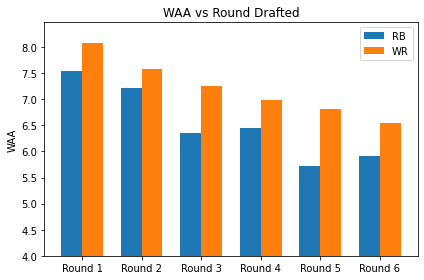

In [94]:
labels = ["Round 1", "Round 2", "Round 3", "Round 4", "Round 5", "Round 6"]
rb_mean_waa = rb_pag.groupby(pd.cut(rb_pag["adp"], bins, right=False)).agg({"waa": "mean"})
wr_mean_waa = wr_pag.groupby(pd.cut(wr_pag["adp"], bins, right=False)).agg({"waa": "mean"})
x = np.arange(len(labels))
width = 0.35

rb_data = [r for r in rb_mean_waa['waa']]
wr_data = [w for w in wr_mean_waa['waa']]

fig, ax = plt.subplots()
ax.bar(x - width/2, rb_data, width, label='RB')
ax.bar(x + width/2, wr_data, width, label='WR')

ax.set_ylim(4)

ax.set_ylabel('WAA')
ax.set_title('WAA vs Round Drafted')
ax.set_xticks(x, labels)


ax.legend()

fig.tight_layout()

plt.show()

Finally, we'll examine what fraction of players in each round at each position fall under the mean WAA for that round:

In [95]:
def below_mean(series):
    return series[series < series.mean()].count() / series.count()

In [96]:
rb_below_mean = rb_pag.groupby(pd.cut(rb_pag["adp"], bins, right="False")).agg({"waa": below_mean})

In [97]:
wr_below_mean = wr_pag.groupby(pd.cut(wr_pag["adp"], bins, right="False")).agg({"waa": below_mean})

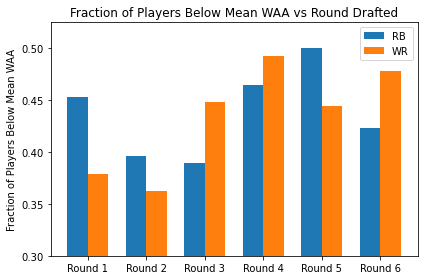

In [98]:
labels = ["Round 1", "Round 2", "Round 3", "Round 4", "Round 5", "Round 6"]
rb_below_mean = rb_pag.groupby(pd.cut(rb_pag["adp"], bins, right="False")).agg({"waa": below_mean})
wr_below_mean = wr_pag.groupby(pd.cut(wr_pag["adp"], bins, right="False")).agg({"waa": below_mean})
x = np.arange(len(labels))
width = 0.35

rb_data = [r for r in rb_below_mean['waa']]
wr_data = [w for w in wr_below_mean['waa']]

fig, ax = plt.subplots()
ax.bar(x - width/2, rb_data, width, label='RB')
ax.bar(x + width/2, wr_data, width, label='WR')

ax.set_ylabel('Fraction of Players Below Mean WAA')
ax.set_title('Fraction of Players Below Mean WAA vs Round Drafted')
ax.set_xticks(x, labels)

ax.set_ylim(0.3)

ax.legend()

fig.tight_layout()

plt.show()

This is an interesting one! It looks like in rounds 1 and 2, the safer bet is to take an elite wide receiver over a running back. However, in rounds 3 and 4, running backs take the lead, with less below-average season performances. This could be affected by RBs being drafted more in earlier rounds, so let's take a look:

In [99]:
rb_pag.groupby(pd.cut(rb_pag["adp"], bins, right=False)).agg({"adp": "count"})

,adp
adp,
"[1.0, 12.5)",85
"[12.5, 24.5)",58
"[24.5, 36.5)",60
"[36.5, 48.5)",43
"[48.5, 60.5)",50
"[60.5, 72.5)",26


In [100]:
wr_pag.groupby(pd.cut(wr_pag["adp"], bins, right=False)).agg({"adp": "count"})

,adp
adp,
"[1.0, 12.5)",37
"[12.5, 24.5)",58
"[24.5, 36.5)",58
"[36.5, 48.5)",69
"[48.5, 60.5)",45
"[60.5, 72.5)",46


RBs are over twice as likely to be drafted in the first round, whereas wide receivers are taken in later rounds. These differences in sample size could result in more error.

# Takeaways

Based on WAA, it's clear that drafting wide receivers early on is the way to go. Injuries to wide receivers are rarer, and the risks of taking a first or second round running back that goes on to bust can result in a losing season.

One thing that's interesting to note is that in rounds 3 and 4, the area widely considered to be the "RB Dead Zone", more wide receivers than running backs end up as "bad picks", that don't perform up to the average of the players drafted around them. More examination here is required, possibly with a time series analysis of how a player performs relative to the players drafted in a 3-pick interval size on either side.